In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

max_degree = 20 # 多项式的最⼤阶数
n_train, n_test = 100, 100 # 训练和测试数据集⼤⼩
true_w = np.zeros(max_degree) # 分配⼤量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

true_w, features, poly_features, labels = [
torch.tensor(x, dtype=torch.float32)
for x in [true_w, features, poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.5312],
         [-0.7280]]),
 tensor([[ 1.0000e+00, -5.3125e-01,  1.4111e-01, -2.4989e-02,  3.3188e-03,
          -3.5262e-04,  3.1221e-05, -2.3695e-06,  1.5735e-07, -9.2878e-09,
           4.9341e-10, -2.3829e-11,  1.0549e-12, -4.3111e-14,  1.6359e-15,
          -5.7938e-17,  1.9237e-18, -6.0115e-20,  1.7742e-21, -4.9608e-23],
         [ 1.0000e+00, -7.2802e-01,  2.6501e-01, -6.4310e-02,  1.1705e-02,
          -1.7043e-03,  2.0679e-04, -2.1507e-05,  1.9572e-06, -1.5832e-07,
           1.1526e-08, -7.6283e-10,  4.6280e-11, -2.5917e-12,  1.3477e-13,
          -6.5412e-15,  2.9764e-16, -1.2746e-17,  5.1553e-19, -1.9753e-20]]),
 tensor([3.8416, 2.9139]))

In [4]:
def evaluate_loss(net, data_iter, loss): #@save
    """评估给定数据集上模型的损失。 """
    metric = d2l.Accumulator(2) # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def train(train_features, test_features, train_labels, test_labels,
num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
    batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
    batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
    xlim=[1, num_epochs], ylim=[1e-3, 1e2],
    legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
            net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())



weight: [[ 4.998384   1.2049154 -3.3962855  5.5955667]]


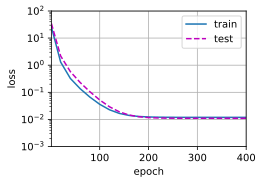

In [5]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
labels[:n_train], labels[n_train:])

weight: [[3.5101206 4.1027994]]


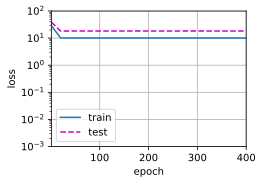

In [6]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
labels[:n_train], labels[n_train:])

weight: [[ 4.9905505   1.2953846  -3.3225636   5.074362   -0.27518097  1.4489723
   0.310309    0.03370693  0.19865032  0.04972177  0.04722092  0.12563229
   0.18285376 -0.05983659  0.07684898  0.07354037  0.19394487 -0.19542553
  -0.18926005  0.15444997]]


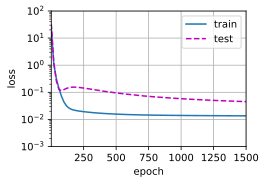

In [7]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
labels[:n_train], labels[n_train:], num_epochs=1500)